- 取り引きデータ  
https://225labo.com/modules/download/
- 取り引き日の考え方  
https://www.jpx.co.jp/derivatives/rules/night-session/index.html
- 移動平均の考え方  
https://faq.rakuten-sec.co.jp/faq_detail.html?id=1102025


In [473]:
import requests
import datetime
from time import sleep

import numpy as np
import pandas as pd
import jpholiday

pd.options.display.max_rows = None
pd.options.display.max_columns = None
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [311]:
data = pd.read_csv('input/N225f_2019.csv').iloc[:,:-1]
print(data.shape)
data.head()

(184004, 6)


,日付,時間,始値,高値,安値,終値
0,2019/1/4,16:30,19820,19820,19790,19800
1,2019/1/4,16:31,19790,19800,19780,19790
2,2019/1/4,16:32,19790,19810,19781,19800
3,2019/1/4,16:33,19790,19810,19790,19800
4,2019/1/4,16:34,19810,19820,19810,19810


In [312]:
# 取引日についてと実時間の出力
def make_traiding_time(x):
    lis = x.replace(':', '/').split('/')
    return datetime.datetime(int(lis[0]), int(lis[1]), int(lis[2]), int(lis[3]), int(lis[4]))

def make_real_time(x):
    if x.time() >= datetime.time(16, 30):
        return x - datetime.timedelta(days=1)
    else:
        return x

data['traiding_time'] = data['日付'] + '/' + data['時間']
data['traiding_time'] = data['traiding_time'].map(make_time)

data['real_time'] = data['traiding_time'].map(make_real_time)

In [313]:
# 曜日の算出 (0:月曜日, 6:日曜日)
def comp_weekday(x):
    date_list = x.split('/')
    weekday = datetime.datetime(int(date_list[0]), int(date_list[1]), int(date_list[2])).weekday()
    return weekday

data['weekday'] = data['日付'].map(comp_weekday)

In [314]:
# 日付情報の分離
data_date = data['日付'].str.split('/', expand=True).astype('int')
data_time = data['時間'].str.split(':', expand=True).astype('int')

# 統合
data_date.columns = ['year', 'month', 'day']
data_time.columns = ['hour', 'min']
data_date = pd.concat([data_date, data_time], axis=1)
data = pd.concat([data_date, data], axis=1)

data.head()

,year,month,day,hour,min,日付,時間,始値,高値,安値,終値,traiding_time,real_time,weekday
0,2019,1,4,16,30,2019/1/4,16:30,19820,19820,19790,19800,2019-01-04 16:30:00,2019-01-03 16:30:00,4
1,2019,1,4,16,31,2019/1/4,16:31,19790,19800,19780,19790,2019-01-04 16:31:00,2019-01-03 16:31:00,4
2,2019,1,4,16,32,2019/1/4,16:32,19790,19810,19781,19800,2019-01-04 16:32:00,2019-01-03 16:32:00,4
3,2019,1,4,16,33,2019/1/4,16:33,19790,19810,19790,19800,2019-01-04 16:33:00,2019-01-03 16:33:00,4
4,2019,1,4,16,34,2019/1/4,16:34,19810,19820,19810,19810,2019-01-04 16:34:00,2019-01-03 16:34:00,4


In [315]:
# 月末の判定
# 月末は1, 月末の最終時間は2

# 月の差分をとって月末フラグを作成。
diff = data['month'].diff().values
diff = np.append(diff[1:], 0)
diff_frag = list(np.where(diff == 1))

# 月末の日付を抽出
end_dates = [data.values[i, 5] for i in diff_frag][0]
# 月末フラグを作成
data['end_of_month_frag'] = data['日付'].map(lambda x: 1 if x in end_dates else 0)

In [316]:
# endfragの作成
data['1min_endfrag'] = 1
data['5min_endfrag'] = 0
data['15min_endfrag'] = 0
data['30min_endfrag'] = 0
data['1h_endfrag'] = 0
data['1d_endfrag'] = 0
data['1w_endfrag'] = 0
data['1m_endfrag'] = 0

# 分単位で欠損がないことを仮定
# 1d, 1w, 1mは15:15を終値としているが、min, h系統は15:14を終値としてとっている...。

data['5min_endfrag'].mask(data['min'] % 5 == 4, 1, inplace=True)

data['15min_endfrag'].mask(data['min'] % 15 == 14, 1, inplace=True)

data['30min_endfrag'].mask(data['min'] % 30 == 14, 1, inplace=True) # 昼と夜で15分ずらして計算したほうがいいのか？（今のままだと、5:30を終値として使えない。5:14になる。）

data['1h_endfrag'].mask(data['min'] == 14, 1, inplace=True) # 今のままだと5:30を終値とできない。5:14を終値とする。

data['1d_endfrag'].mask((data['hour'] == 15) & (data['min'] == 15), 1, inplace=True) # 一日の終値は日中取引の終値をいう。

data['1w_endfrag'].mask((data['weekday'] == 4) & (data['hour'] == 15) & (data['min'] == 15), 1, inplace=True)

data['1m_endfrag'].mask((data['end_of_month_frag'] == 1) & (data['hour'] == 15) & (data['min'] == 15), 1, inplace=True)


In [392]:
data.head()

,real_time,traiding_time,weekday,始値,高値,安値,終値,1min_endfrag,5min_endfrag,15min_endfrag,1h_endfrag,1d_endfrag,1w_endfrag,1m_endfrag
182830,2019-08-26 15:14:00,2019-08-26 15:14:00,0,20280,20280,20280,20280,1,1,1,1,0,0,0
182876,2019-08-26 17:14:00,2019-08-27 17:14:00,1,20450,20450,20450,20450,1,1,1,1,0,0,0
182936,2019-08-26 18:14:00,2019-08-27 18:14:00,1,20530,20530,20530,20530,1,1,1,1,0,0,0
182996,2019-08-26 19:14:00,2019-08-27 19:14:00,1,20530,20530,20530,20530,1,1,1,1,0,0,0
183056,2019-08-26 20:14:00,2019-08-27 20:14:00,1,20520,20520,20520,20520,1,1,1,1,0,0,0


In [393]:
data = data.loc[:, ['real_time', '始値', '高値', '安値', '終値', '1min_endfrag', '5min_endfrag', '15min_endfrag', '1h_endfrag', 
                   '1d_endfrag', '1w_endfrag', '1m_endfrag']]
data.head()

,real_time,traiding_time,weekday,始値,高値,安値,終値,1min_endfrag,5min_endfrag,15min_endfrag,1h_endfrag,1d_endfrag,1w_endfrag,1m_endfrag
182830,2019-08-26 15:14:00,2019-08-26 15:14:00,0,20280,20280,20280,20280,1,1,1,1,0,0,0
182876,2019-08-26 17:14:00,2019-08-27 17:14:00,1,20450,20450,20450,20450,1,1,1,1,0,0,0
182936,2019-08-26 18:14:00,2019-08-27 18:14:00,1,20530,20530,20530,20530,1,1,1,1,0,0,0
182996,2019-08-26 19:14:00,2019-08-27 19:14:00,1,20530,20530,20530,20530,1,1,1,1,0,0,0
183056,2019-08-26 20:14:00,2019-08-27 20:14:00,1,20520,20520,20520,20520,1,1,1,1,0,0,0


In [456]:
# data_row = data.copy()
data = data_row.copy()

#### 時間移動平均
取り引きされていない間の計算式をどうするか

In [457]:
dic_k = {'1min': 1, '5min':5, '15min':15, '30min':30, '1h':60, '1d':24 * 60, '1w':7 * 24 * 60, '1m':31 * 24 * 60}
dic_endfrag = {'1min': '1min_endfrag', '5min': '5min_endfrag', '15min':'15min_endfrag', '30min':'30min_endfrag', '1h':'1h_endfrag', 
               '1d':'1d_endfrag', '1w':'1w_endfrag', '1m':'1m_endfrag'}

# 何分時間移動平均か 
N = 14 * 24 * 60 # 14日

# 時間分解能を選択
TIME_LEG = '1d'

# 考慮データ数
num_data = int(N / dic_k[TIME_LEG])
print(num_data)

# 現在の値の反映を考える。
data_now = data.iloc[-1, :] # 現在の値

14


In [458]:
# 時間分解能に対応する、各足の終値を取得
data = data[data[dic_endfrag[TIME_LEG]] == 1]

# 末尾が一致していないなら現在の物を加える　。一致しているならそのままでいい。
if data_now[dic_endfrag[TIME_LEG]] != 1: 
    data = pd.concat([data, pd.DataFrame(data_now).T], axis=0)

# この段階で差分、単純移動平均を計算しておく。（これは差分、移動平均ともに休止期間中の値は休止直前の値を取っているに等しい）
# 単独計算
# SMA
SMA =  data['終値'].tail(num_data).mean()
# RSI
diff = data['終値'].diff().tail(num_data)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
RSI = up.mean() / (up.mean() + down.abs().mean()) * 100

# 全体計算
# SMA
data['SMA'] = data['終値'].rolling(window=num_data).mean()
# RSI
diff = data['終値'].diff()
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
up = up.rolling(window=num_data).mean()
down = down.abs().rolling(window=num_data).mean()
data['RSI'] = up / (up + down) * 100

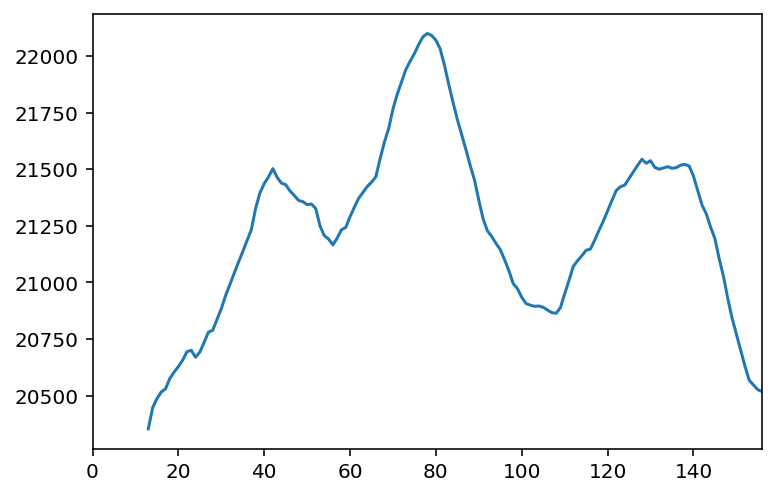

In [470]:
data['SMA'].reset_index(drop=True).plot()

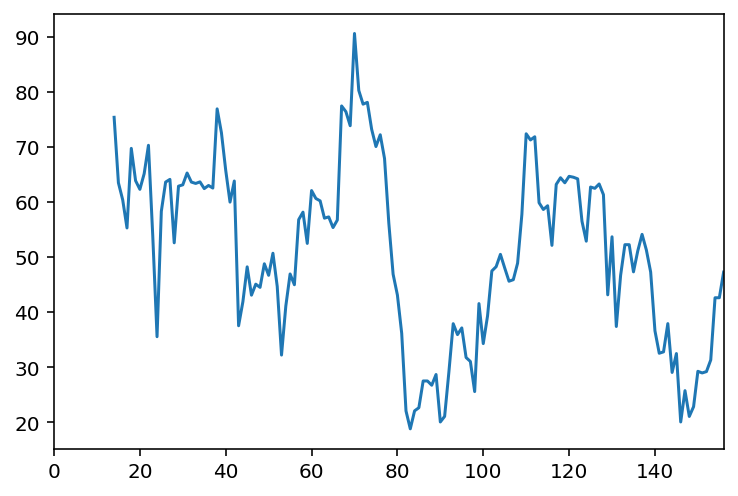

In [471]:
data['RSI'].reset_index(drop=True).plot()